### Geospatial Analysis and Visualization of Hurricane Florence's Trajectory: Unveiling Patterns and Implications from August 30th to September 18th, 2018

Hurricane Florence left an estimated property damage and disruption amounting to [$17-22 billion](https://www.cnbc.com/2018/09/17/moodys-hurricane-florence-damage-estimated-at-17-to-22-billion.html) when it passed through part of the East Coast of the United States, according to Moody's Analytics.

This project aims to find out where it came from, when and where it got stronger, and understand more about this natural disaster using Python.

#### Importing all necessary packages

Data sources:

US States deospatial data, 5m, GeoJSON file: https://eric.clst.org/tech/usgeojson/

Hurricane Florence data, florence.csv: https://flhurricane.com/cyclone/stormhistory.php?storm=6&year=2018



In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point
import missingno as msn

%matplotlib inline


In [66]:
country = geopandas.read_file("C:/Users/Renz/Documents/GitHub/Geospatial Analysis of Hurricane Florence's Path/Geospatial-Analysis-of-Hurricane-Florence-s-Path/gz_2010_us_040_00_5m.json")
country.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [67]:
type(country)

geopandas.geodataframe.GeoDataFrame

In [68]:
country.geometry.head()

0    MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...
1    MULTIPOLYGON (((-166.10574 53.98861, -166.0752...
2    POLYGON ((-112.53859 37.00067, -112.53454 37.0...
3    POLYGON ((-94.04296 33.01922, -94.04304 33.079...
4    MULTIPOLYGON (((-122.42144 37.86997, -122.4213...
Name: geometry, dtype: geometry

In [69]:
type(country.geometry)

geopandas.geoseries.GeoSeries

In [70]:
type(country.geometry[0])

shapely.geometry.multipolygon.MultiPolygon

<Axes: >

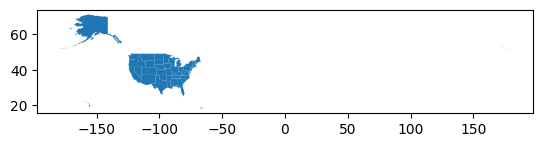

In [71]:
country.plot()

<Axes: >

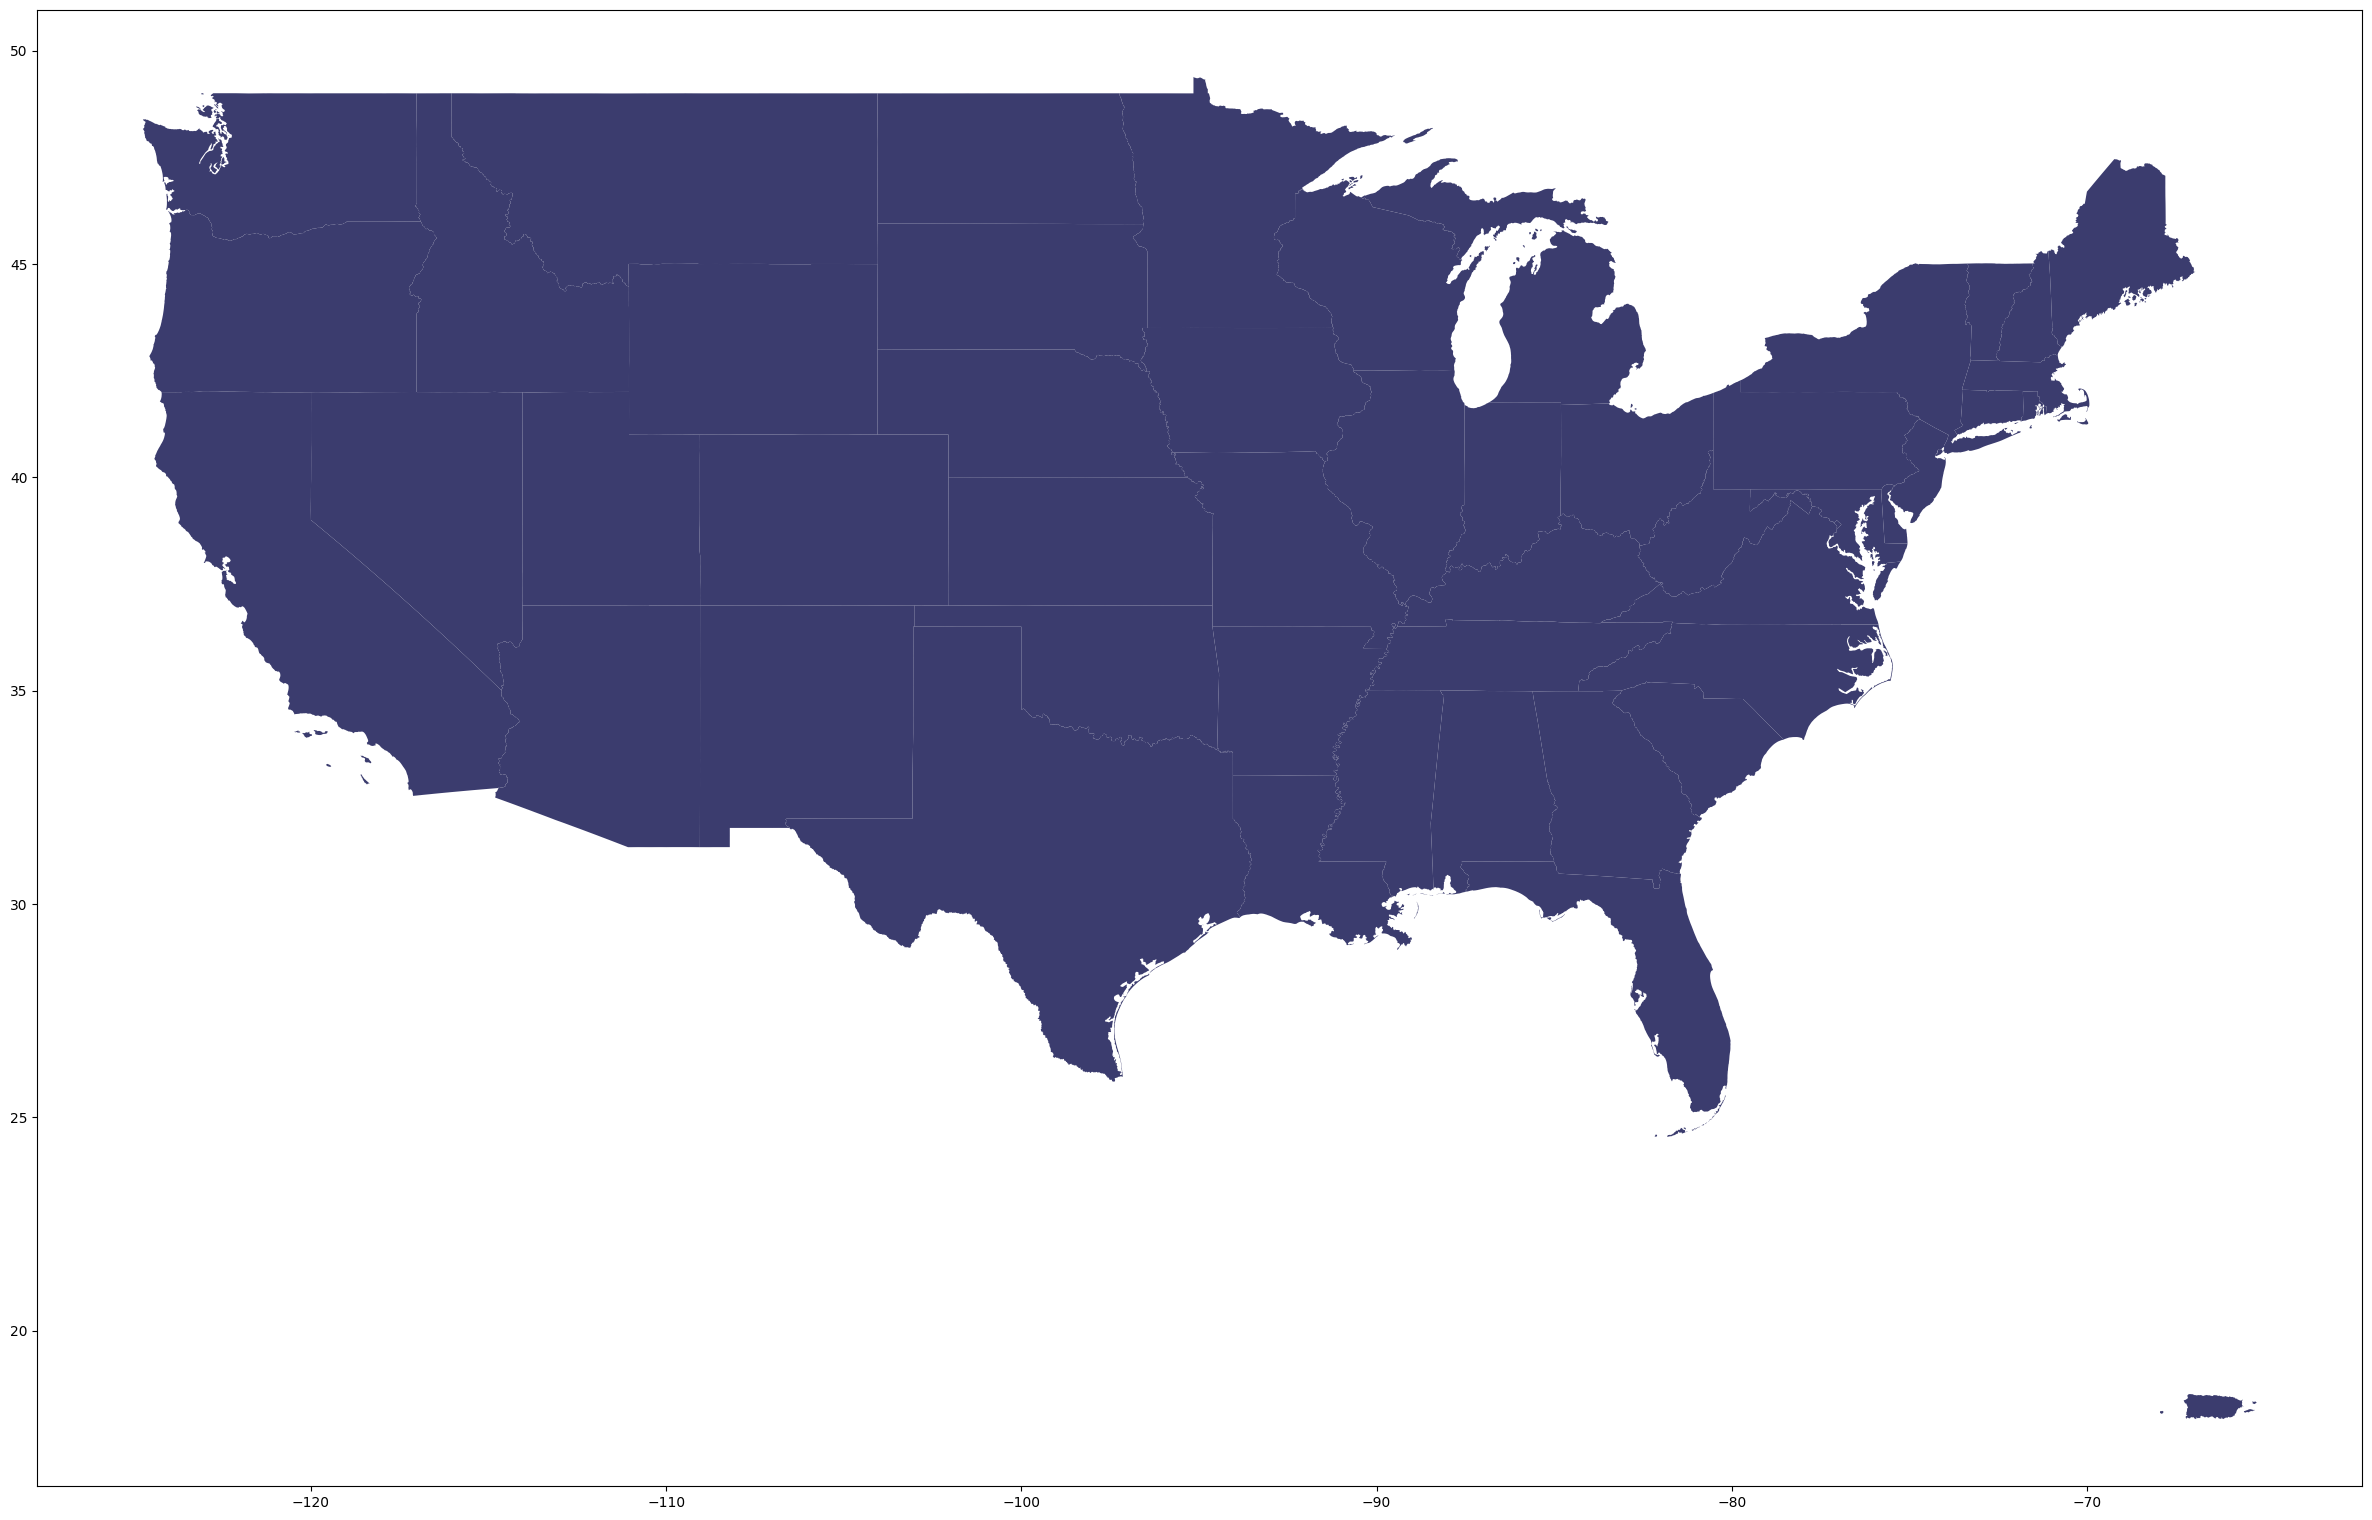

In [72]:
# Excluding Alaska and Hawaii
country[country['NAME'].isin(['Alaska', 'Hawaii'])== False].plot(figsize = (30, 20), color='#3B3C6E')

In [73]:
florence = pd.read_csv("C:/Users/Renz/Documents/GitHub/Geospatial Analysis of Hurricane Florence's Path/Geospatial-Analysis-of-Hurricane-Florence-s-Path/florence.csv")

# Converting wind speed to kilometers per hour
florence['Wind'] = florence['Wind'] * 1.60934
florence['Wind'] = florence['Wind'].round()

florence.head()

,AdvisoryNumber,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Received,Forecaster
0,1,08/30/2018 11:00,12.9,18.4,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 10:45,Avila
1,1A,08/30/2018 14:00,12.9,19.0,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 13:36,Avila
2,2,08/30/2018 17:00,12.9,19.4,48.0,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 16:36,Avila
3,2A,08/30/2018 20:00,13.1,20.4,48.0,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 19:44,Beven
4,3,08/30/2018 23:00,13.2,20.9,56.0,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,08/30/2018 22:42,Beven


In [120]:
# Define Saffir-Simpson category thresholds (kph)
hurricane_category = {
    1: (119, 153),
    2: (154, 177),
    3: (178, 208),
    4: (209, 251),
    5: (252, float('inf'))}

# Create a new column for category based on wind speed
def categorize_wind_speed(Wind):
  for category, (lower_bound, upper_bound) in hurricane_category.items():
    if lower_bound <= Wind < upper_bound:
      return category
  return None

#florence['Hurricane Category'] = florence['Wind'].apply(categorize_wind_speed)

# Print the modified dataframe
#florence.tail()

In [119]:
hurricane_category.items()

dict_items([(1, (119, 153)), (2, (154, 177)), (3, (178, 208)), (4, (209, 251)), (5, (252, inf))])

#### Exploratory Data Analysis

Missing values in Florence dataset were checked and visualized using the missingno package. A much simpler approach is to use the .info() method. There is one missing value on the Forecaster column, but this column was not needed anyway and was eventually dropped along with AdvisoryNumber and Received columns.

In [76]:
florence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AdvisoryNumber      105 non-null    object 
 1   Date                105 non-null    object 
 2   Lat                 105 non-null    float64
 3   Long                105 non-null    float64
 4   Wind                105 non-null    float64
 5   Pres                105 non-null    int64  
 6   Movement            105 non-null    object 
 7   Type                105 non-null    object 
 8   Name                105 non-null    object 
 9   Received            105 non-null    object 
 10  Forecaster          104 non-null    object 
 11  Hurricane Category  41 non-null     float64
dtypes: float64(4), int64(1), object(7)
memory usage: 10.0+ KB


<Axes: >

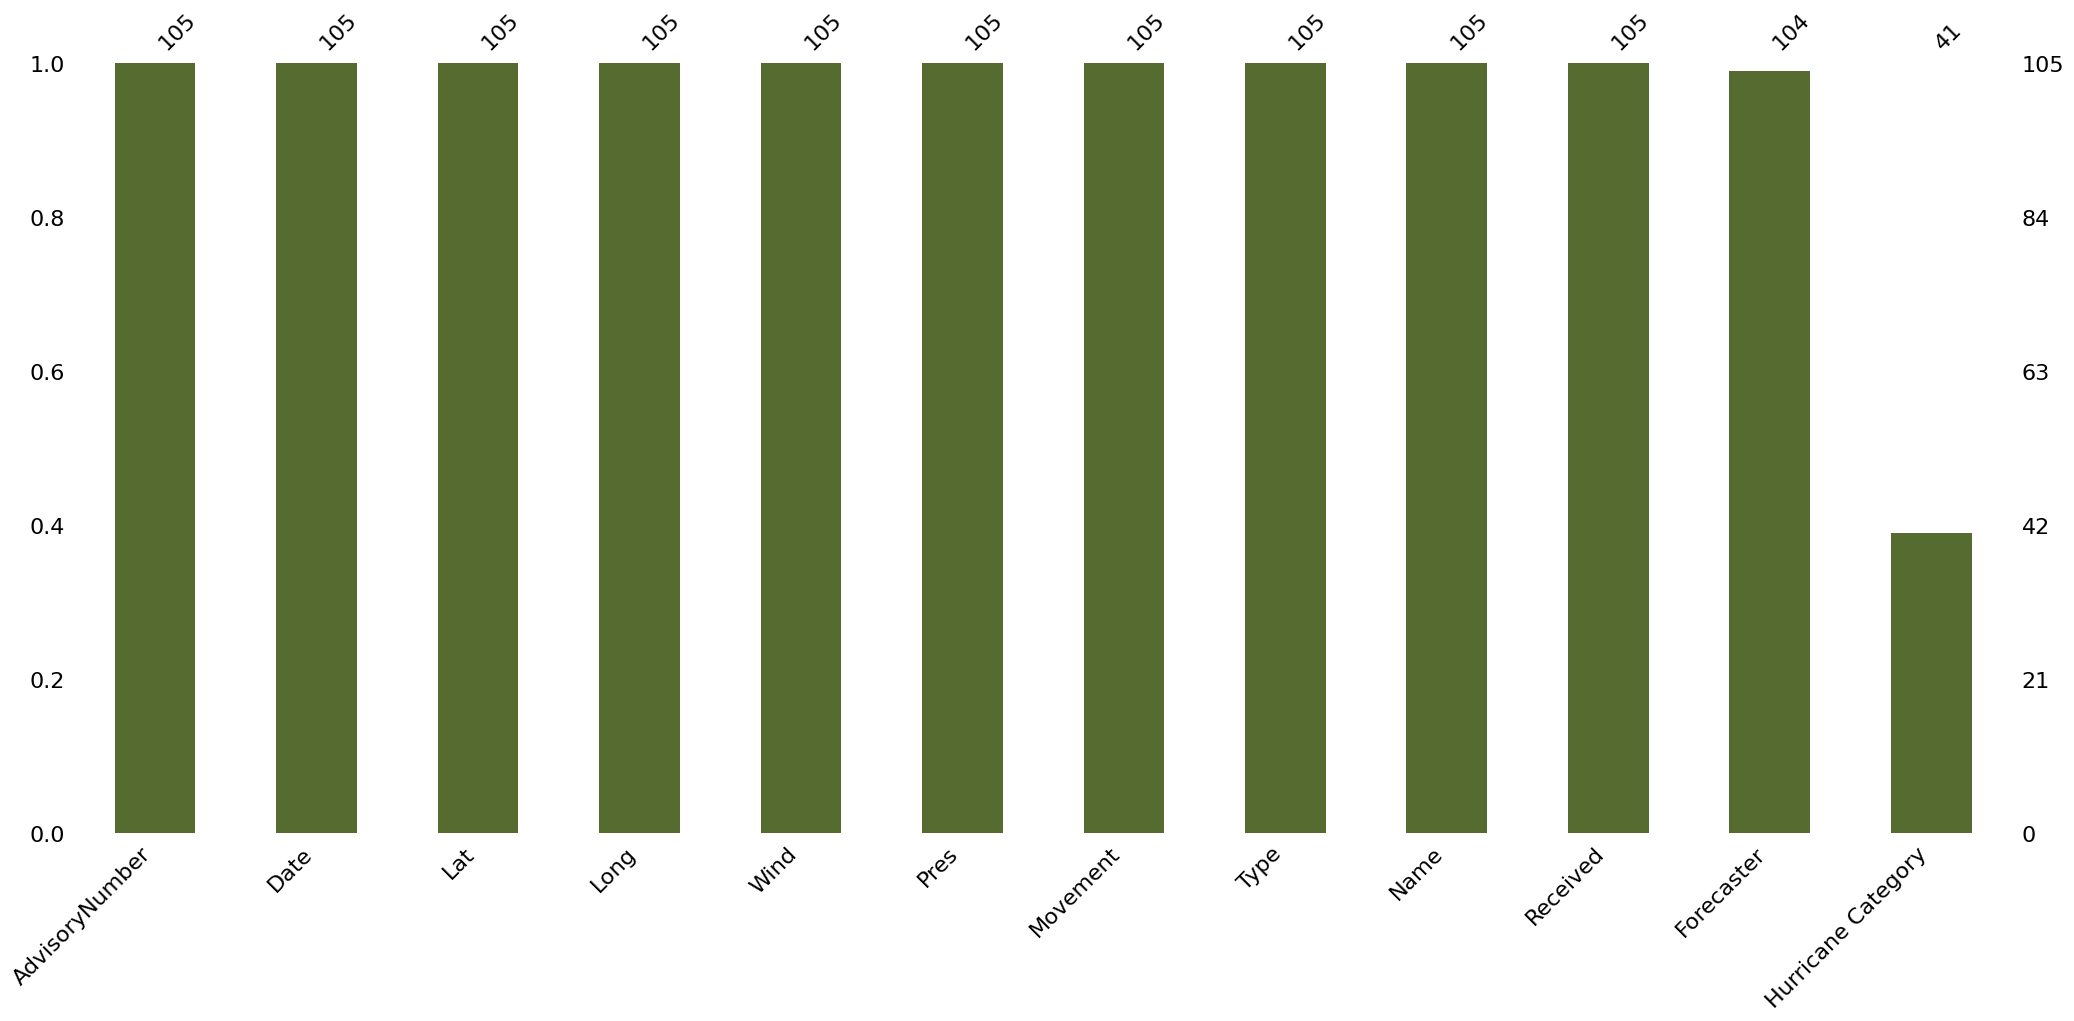

In [77]:
msn.bar(florence, color='darkolivegreen')

In [78]:
florence.describe()

,Lat,Long,Wind,Pres,Hurricane Category
count,105.000000,105.000000,105.000000,105.000000,41.000000
mean,25.931429,56.938095,119.704762,981.571429,2.560976
std,7.975917,20.878865,58.889062,22.780667,1.245969
min,12.900000,18.400000,40.000000,939.000000,1.000000
25%,18.900000,41.000000,64.000000,956.000000,1.000000
50%,25.100000,60.000000,113.000000,989.000000,3.000000
75%,33.600000,76.400000,169.000000,1002.000000,4.000000
max,42.600000,82.900000,225.000000,1008.000000,4.000000


Only working on date, latitude, longitude, wind speed, pressure, and name columns, the rest of unused columns were dropped.

In [79]:
florence = florence.drop(['AdvisoryNumber', 'Received', 'Forecaster'], axis=1)
florence.head()

,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Hurricane Category
0,08/30/2018 11:00,12.9,18.4,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN
1,08/30/2018 14:00,12.9,19.0,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN
2,08/30/2018 17:00,12.9,19.4,48.0,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,NaN
3,08/30/2018 20:00,13.1,20.4,48.0,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,NaN
4,08/30/2018 23:00,13.2,20.9,56.0,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,NaN


Here the longitude is west so a "-" was added in front of the number to correctly plot the data.

In [80]:
florence['Long'] = 0 - florence['Long']
florence.head()

,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Hurricane Category
0,08/30/2018 11:00,12.9,-18.4,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN
1,08/30/2018 14:00,12.9,-19.0,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN
2,08/30/2018 17:00,12.9,-19.4,48.0,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,NaN
3,08/30/2018 20:00,13.1,-20.4,48.0,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,NaN
4,08/30/2018 23:00,13.2,-20.9,56.0,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,NaN


Latitude and Longitude were combined to create hurricane Coordinates column. For visualization purposes, the Coordinates column was converted into GeoPoint.

In [81]:
florence['Coordinates'] = florence[['Long', 'Lat']].values.tolist()
florence.head()

,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Hurricane Category,Coordinates
0,08/30/2018 11:00,12.9,-18.4,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,"[-18.4, 12.9]"
1,08/30/2018 14:00,12.9,-19.0,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,"[-19.0, 12.9]"
2,08/30/2018 17:00,12.9,-19.4,48.0,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,"[-19.4, 12.9]"
3,08/30/2018 20:00,13.1,-20.4,48.0,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,"[-20.4, 13.1]"
4,08/30/2018 23:00,13.2,-20.9,56.0,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,"[-20.9, 13.2]"


In [82]:
florence['Coordinates'] = florence['Coordinates'].apply(Point)
florence.head()

,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Hurricane Category,Coordinates
0,08/30/2018 11:00,12.9,-18.4,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-18.4 12.9)
1,08/30/2018 14:00,12.9,-19.0,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-19 12.9)
2,08/30/2018 17:00,12.9,-19.4,48.0,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-19.4 12.9)
3,08/30/2018 20:00,13.1,-20.4,48.0,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-20.4 13.1)
4,08/30/2018 23:00,13.2,-20.9,56.0,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-20.9 13.2)


By checking, the data type of florence and its Coordinates column are pandas DataFrame and Series, respectively. These were converted into GeoDataFrame and GeoSeries, or into geospatial data, using the geopandas package. 

In [83]:
florence = geopandas.GeoDataFrame(florence, geometry='Coordinates')
florence.head()

,Date,Lat,Long,Wind,Pres,Movement,Type,Name,Hurricane Category,Coordinates
0,08/30/2018 11:00,12.9,-18.4,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-18.40000 12.90000)
1,08/30/2018 14:00,12.9,-19.0,48.0,1007,W at 12 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-19.00000 12.90000)
2,08/30/2018 17:00,12.9,-19.4,48.0,1007,W at 9 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-19.40000 12.90000)
3,08/30/2018 20:00,13.1,-20.4,48.0,1007,W at 11 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-20.40000 13.10000)
4,08/30/2018 23:00,13.2,-20.9,56.0,1007,W at 13 MPH (280 deg),Potential Tropical Cyclone,Six,NaN,POINT (-20.90000 13.20000)


In [84]:
type(florence['Coordinates'])

geopandas.geoseries.GeoSeries

In [85]:
type(florence)

geopandas.geodataframe.GeoDataFrame

In [86]:
florence.groupby('Name').Type.count()

Name
FLORENCE     6
Florence    85
SIX          4
Six         10
Name: Type, dtype: int64

Finding the mean and maximum wind speed of hurricane Florence

In [87]:
print("Mean wind speed: {} kph".format(round(florence.Wind.mean(), 3)))

Mean wind speed: 119.705 kph


In [88]:
print("Maximum wind speed: {} kph".format(round(florence.Wind.max(), 3)))

Maximum wind speed: 225.0 kph


#### Visualization

C:\Users\Renz\AppData\Local\Temp\ipykernel_19056\3009375851.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Oranges")  # Choose a colormap (adjust as desired)


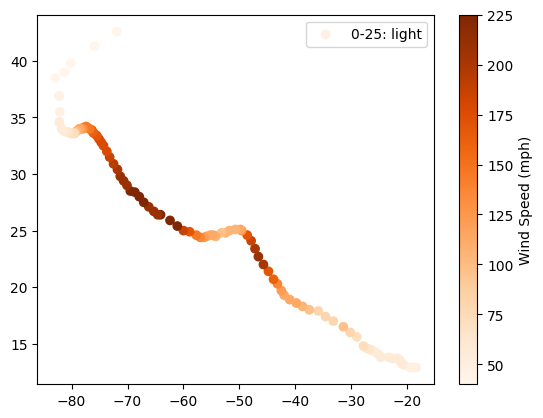

In [89]:
#florence.plot(figsize=(20, 10))

from matplotlib.cm import ScalarMappable
fig, ax = plt.subplots()
wind_speeds = florence['Wind']

#wind_ranges = [('<=25', 'light'), ('25-35', 'moderate'), ('35-60', 'strong'), 
 #                ('60-77', 'severe'), ('77-111', 'extreme'), ('111-140+', 'catastrophic')]

x = florence['Long']
y = florence['Lat']

wind_ranges = [(0, 25, "light"), (25, 35, "moderate"), (35, 60, "strong")]

cmap = plt.cm.get_cmap("Oranges")  # Choose a colormap (adjust as desired)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(min(wind_speeds), max(wind_speeds)))
sm.set_array([])  # Set an empty array

# Scatter plot with color based on wind speed
plt.scatter(x, y, c=wind_speeds, cmap=cmap)  # Replace x and y with your actual data

# Create a legend for the colorbar
plt.colorbar(sm, label="Wind Speed (mph)", ax=ax)

# Optional: Add labels for wind speed ranges in the legend (manually)
legend_labels = [f"{r[0]}-{r[1]}: {r[2]}" for r in wind_ranges]
plt.legend(loc="best", labels=legend_labels)
plt.show()

C:\Users\Renz\AppData\Local\Temp\ipykernel_19056\4205924905.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Oranges")


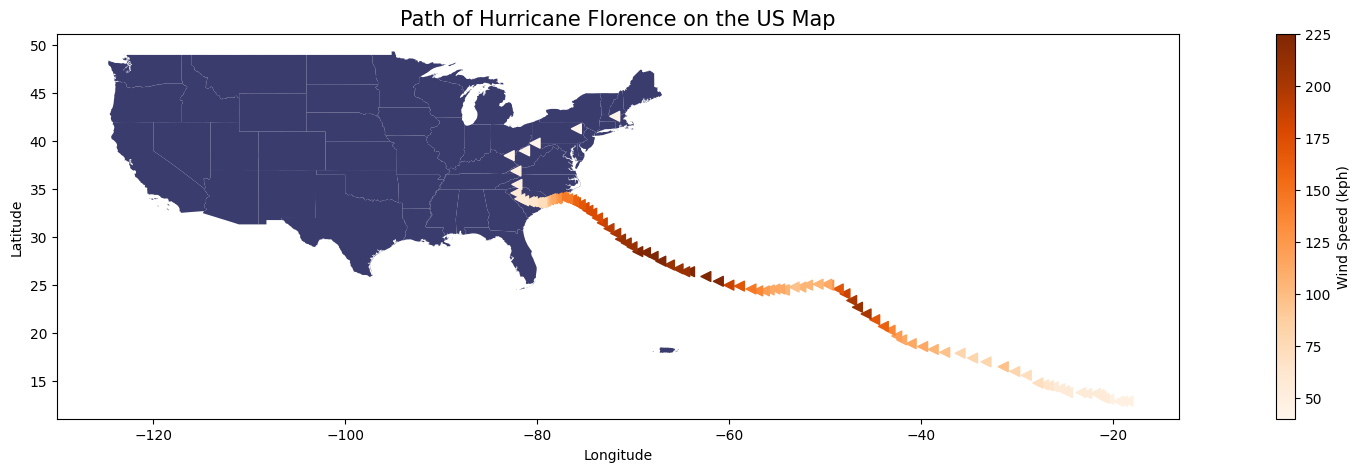

In [148]:
from matplotlib.cm import ScalarMappable

# Plotting the US map
fig, ax = plt.subplots(1, figsize=(25, 5))
map = country[country['NAME'].isin(['Alaska', 'Hawaii'])== False].plot(ax=ax, color='#3B3C6E')

# Overlaying the hurricane position on the US map
florence.plot(ax=map,
              column='Wind',
              marker='<',
              markersize=50,
              cmap='Oranges')

cmap = plt.cm.get_cmap("Oranges")
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(min(florence['Wind']), max(florence['Wind'])))
sm.set_array([]) # initializing the scalar mappable with an empty array

plt.colorbar(sm, label="Wind Speed (kph)", ax=ax)

ax.set_title('Path of Hurricane Florence on the US Map', fontsize=15)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)

# plt.legend(labels=["Wind Speed (mph)\ndarker = stronger"],
#            fontsize=13,
#            facecolor='#3B3C6E',
#            markerscale=1,
#            loc='best',
#            scatterpoints=3,
#            fancybox=True,
#            edgecolor='#3B3C6E')

#turn_off_axis = ax.axis('off')

plt.show()